Reference: [Recommendation System Implementation With Deep Learning and PyTorch](https://medium.com/swlh/recommendation-system-implementation-with-deep-learning-and-pytorch-a03ee84a96f4)

In [486]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import math
import copy
from pathlib import Path
from itertools import zip_longest

In [487]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [488]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

# Prepare data

In [489]:
def read_data(path):
    files = {}
    for filename in path.glob('*'):
        if filename.suffix == '.csv':
            files[filename.stem] = pd.read_csv(filename)
    return files['input']
input_df = read_data(Path('data/input'))

In [490]:
input_df.head()

,Schedule,Time,Distance,Task,Duration,Response
0,01110101101111101100110010011001,4,6.410645,0,0.099414,1
1,10111101010010010000011111001111,18,6.420521,1,1.003221,1
2,10010110110100000010110010000111,17,3.342021,0,1.399248,0
3,00100001001100011101010001000001,8,3.778492,1,0.546982,1
4,00110100101110100001000011000111,28,8.843591,1,0.780142,1


In [491]:
def create_dataset(input_df, top=None):    
    num_entries = input_df.shape[0]
    num_fields = input_df.shape[1] - 1
    
    # input['Schedule'] = [np.array(list(one_hot_str), dtype=np.float32) for one_hot_str in input['Schedule']]
    # input['Schedule'] = input['Schedule'].apply(lambda x: torch.tensor(x))

    X = input.drop(['Response'], axis=1)
    y = input['Response'].astype(int)
    return (num_entries, num_fields), (X, y)

In [492]:
(num_entries, num_fields), (X, y) = create_dataset(input)
print(f'{num_entries} entries, {num_fields} fields')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

100 entries, 5 fields
Dataset shape: (100, 5)
Target shape: (100,)


In [493]:
class ReviewsIterator:
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [494]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = [[
                torch.tensor(x_field).float() 
                if isinstance(x_field, (int, float)) else x_field for x_field in x
            ] for x in xb]
        xb = [[
                torch.tensor(np.array([int(digit) for digit in x_field])) 
                if isinstance(x_field, str) else x_field for x_field in x
            ] for x in xb]

        xb = [torch.cat([x[0].unsqueeze(0)] + [torch.tensor([[elem]]) for elem in x[1:]], dim=1) for x in xb]
        
        xb = torch.stack(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [495]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[[1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
          1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
          1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
          0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
          1.0000e+00, 1.0000e+00, 2.8000e+01, 5.6708e+00, 1.0000e+00,
          1.9840e+00]],

        [[1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
          1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
          0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
          1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
          1.0000e+00, 1.0000e+00, 1.6000e+01, 7.5592e+00, 1.0000e

# Model

In [496]:
class RecommendationModel(nn.Module):
    def __init__(self, num_features, num_factors=50, embedding_dropout=0.02, hidden=10, dropouts=0.2):
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]

        def gen_layers(n_in):
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)

            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out

        self.features = nn.Linear(num_features, num_factors * 2)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(num_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()

    def forward(self, x):
        x = self.features(x)
        x = self.drop(x)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        return out

    def _init(self):
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.features.apply(init)
        self.hidden.apply(init)
        init(self.fc)


def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuration should be a single number or a list of numbers')

In [497]:
RecommendationModel(num_features=num_fields, num_factors=5, hidden=100, dropouts=0.1)

RecommendationModel(
  (features): Linear(in_features=5, out_features=10, bias=True)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

# Training

### Cyclical Learing Rate

In [498]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [499]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [500]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [501]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

### Training Loop

In [502]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

print(dataset_sizes)

{'train': 80, 'val': 20}


In [503]:
rec = RecommendationModel(
    num_features=36, 
    num_factors=150,
    hidden=[100, 200, 300],
    dropouts=[0.25, 0.5]
)
print(rec)

RecommendationModel(
  (features): Linear(in_features=36, out_features=300, bias=True)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)


In [504]:
lr = 1e-3
wd = 1e-5
bs = 10
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

rec.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(rec.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

In [505]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        if phase == 'train':
            training = True
        else:
            training = False

        running_loss = 0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            x_batch = x_batch.view(x_batch.size(0), -1)
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = rec(x_batch)
                loss = criterion(outputs, y_batch)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(rec.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/100] train: 0.2918 - val: 0.3730
loss improvement on epoch: 2
[002/100] train: 0.2911 - val: 0.2393


/Users/sharon/opt/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[003/100] train: 0.2484 - val: 0.2786
[004/100] train: 0.2620 - val: 0.3671
[005/100] train: 0.2685 - val: 0.3692
[006/100] train: 0.3180 - val: 0.3160
loss improvement on epoch: 7
[007/100] train: 0.2840 - val: 0.2193
[008/100] train: 0.2863 - val: 0.3057
[009/100] train: 0.2796 - val: 0.2760
[010/100] train: 0.2754 - val: 0.3049
[011/100] train: 0.2305 - val: 0.2788
loss improvement on epoch: 12
[012/100] train: 0.2801 - val: 0.1993
[013/100] train: 0.2844 - val: 0.3076
[014/100] train: 0.2378 - val: 0.2410
[015/100] train: 0.2466 - val: 0.2848
[016/100] train: 0.2648 - val: 0.2496
[017/100] train: 0.2978 - val: 0.3357
[018/100] train: 0.2302 - val: 0.2630
[019/100] train: 0.2507 - val: 0.2105
[020/100] train: 0.2488 - val: 0.2371
[021/100] train: 0.2302 - val: 0.2968
[022/100] train: 0.2346 - val: 0.2836
early stopping after epoch 022


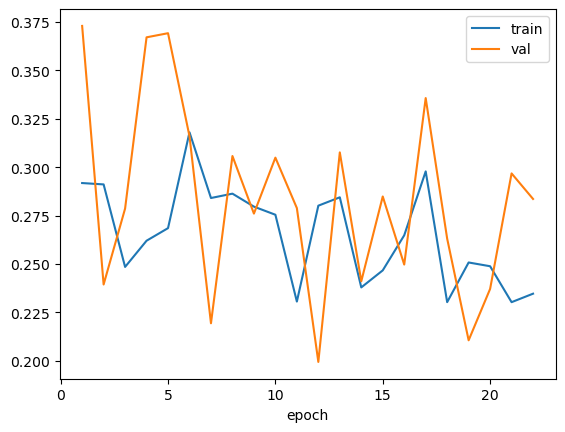

In [506]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

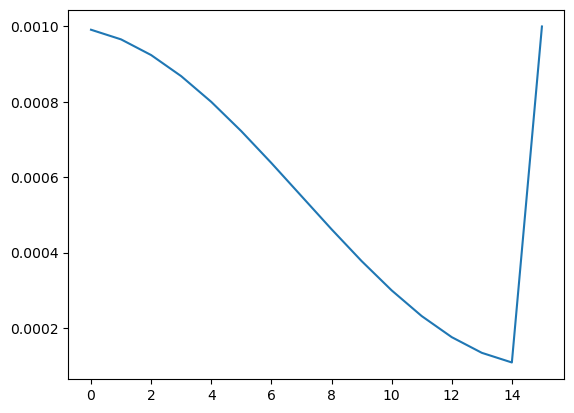

In [507]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

In [508]:
rec.load_state_dict(best_weights)

<All keys matched successfully>

In [509]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = rec(x_batch)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

print(f'groud_truth: {groud_truth}')
print(f'predictions: {predictions}')
print(f'decision: {np.round(predictions).astype(int)}')

groud_truth: [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.]
predictions: [0.39411405 0.38354781 0.48281825 0.34101811 0.21569127 0.50318849
 0.75219136 0.45678529 0.27463475 0.37356198 0.73172557 0.42592317
 0.57699555 0.69961512 0.39734876 0.48539096 0.61333507 0.13948952
 0.49737042 0.49214059]
decision: [0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0]
